# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

import math

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

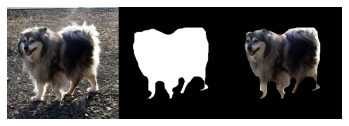

In [6]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [0]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

Epoch 1/20
219/219 [==============================] - 76s 347ms/step - loss: 0.5644 - mean_iou: 0.1318 - val_loss: 0.4566 - val_mean_iou: 0.3629
i= 1 loss= 0.5644203868086479 val_loss= 0.45664212107658386 mean_iou= 0.13176762 val_mean_iou= 0.3628755509853363


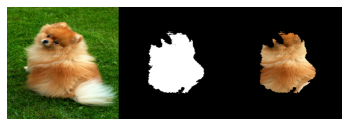

Epoch 2/20
219/219 [==============================] - 73s 335ms/step - loss: 0.4497 - mean_iou: 0.4444 - val_loss: 0.4256 - val_mean_iou: 0.4820
i= 2 loss= 0.4496918649978289 val_loss= 0.4255646765232086 mean_iou= 0.4443804 val_mean_iou= 0.48201799392700195


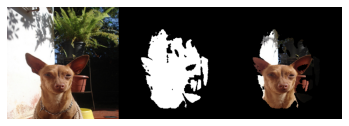

Epoch 3/20
219/219 [==============================] - 72s 329ms/step - loss: 0.4280 - mean_iou: 0.4656 - val_loss: 0.4229 - val_mean_iou: 0.5146
i= 3 loss= 0.4279873164277099 val_loss= 0.4228930175304413 mean_iou= 0.46560135 val_mean_iou= 0.5146090984344482


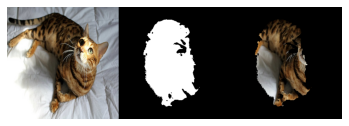

Epoch 4/20
219/219 [==============================] - 73s 332ms/step - loss: 0.3950 - mean_iou: 0.5071 - val_loss: 0.3100 - val_mean_iou: 0.5780
i= 4 loss= 0.39499348116247623 val_loss= 0.31001943349838257 mean_iou= 0.50705045 val_mean_iou= 0.5779821872711182


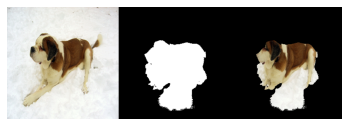

Epoch 5/20
219/219 [==============================] - 73s 332ms/step - loss: 0.3536 - mean_iou: 0.5735 - val_loss: 0.3258 - val_mean_iou: 0.6029
i= 5 loss= 0.3536347907427783 val_loss= 0.3258339762687683 mean_iou= 0.57349306 val_mean_iou= 0.6028757691383362


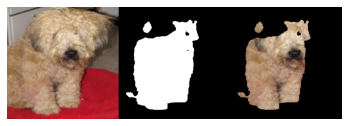

Epoch 6/20
219/219 [==============================] - 73s 332ms/step - loss: 0.3152 - mean_iou: 0.6250 - val_loss: 0.2637 - val_mean_iou: 0.6688
i= 6 loss= 0.3152127854492022 val_loss= 0.26367807388305664 mean_iou= 0.6250421 val_mean_iou= 0.6688121557235718


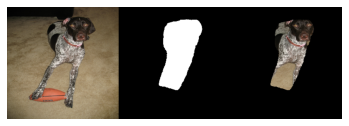

Epoch 7/20
219/219 [==============================] - 73s 331ms/step - loss: 0.2866 - mean_iou: 0.6622 - val_loss: 0.2600 - val_mean_iou: 0.6869
i= 7 loss= 0.28659856196952194 val_loss= 0.2599782943725586 mean_iou= 0.6621782 val_mean_iou= 0.6869302988052368


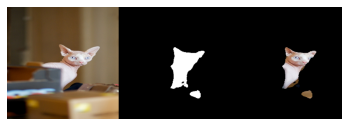

Epoch 8/20
219/219 [==============================] - 73s 334ms/step - loss: 0.2550 - mean_iou: 0.6935 - val_loss: 0.3484 - val_mean_iou: 0.6925
i= 8 loss= 0.25501765746232036 val_loss= 0.348379522562027 mean_iou= 0.69350165 val_mean_iou= 0.6925485730171204


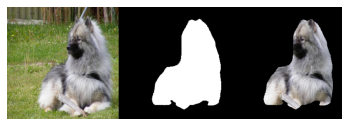

Epoch 9/20
219/219 [==============================] - 73s 333ms/step - loss: 0.2356 - mean_iou: 0.7196 - val_loss: 0.2349 - val_mean_iou: 0.6950
i= 9 loss= 0.23559083309892107 val_loss= 0.2349354326725006 mean_iou= 0.71959543 val_mean_iou= 0.6949686408042908


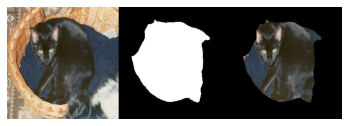

Epoch 10/20
219/219 [==============================] - 72s 329ms/step - loss: 0.2176 - mean_iou: 0.7360 - val_loss: 0.2017 - val_mean_iou: 0.7240
i= 10 loss= 0.21756701627278438 val_loss= 0.20169037580490112 mean_iou= 0.7359519 val_mean_iou= 0.7240419983863831


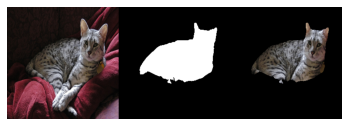

Epoch 11/20
219/219 [==============================] - 74s 337ms/step - loss: 0.2023 - mean_iou: 0.7581 - val_loss: 0.2915 - val_mean_iou: 0.6885
i= 11 loss= 0.20226024533515652 val_loss= 0.2914515435695648 mean_iou= 0.7580578 val_mean_iou= 0.6885067224502563


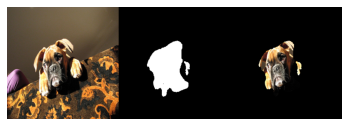

Epoch 12/20
219/219 [==============================] - 72s 330ms/step - loss: 0.1905 - mean_iou: 0.7686 - val_loss: 0.2328 - val_mean_iou: 0.7324
i= 12 loss= 0.1905482312043508 val_loss= 0.2328345775604248 mean_iou= 0.76855344 val_mean_iou= 0.7323636412620544


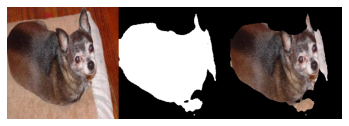

Epoch 13/20
219/219 [==============================] - 73s 335ms/step - loss: 0.1783 - mean_iou: 0.7830 - val_loss: 0.2169 - val_mean_iou: 0.7269
i= 13 loss= 0.17834421192810415 val_loss= 0.2168845683336258 mean_iou= 0.78299654 val_mean_iou= 0.7269448041915894


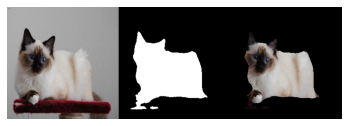

Epoch 14/20
219/219 [==============================] - 72s 327ms/step - loss: 0.1675 - mean_iou: 0.7938 - val_loss: 0.2044 - val_mean_iou: 0.7535
i= 14 loss= 0.16747729568720954 val_loss= 0.20441490411758423 mean_iou= 0.7937877 val_mean_iou= 0.7535123825073242


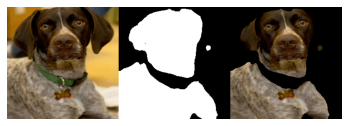

Epoch 15/20
219/219 [==============================] - 72s 329ms/step - loss: 0.1540 - mean_iou: 0.8075 - val_loss: 0.1967 - val_mean_iou: 0.7453
i= 15 loss= 0.15404288695283133 val_loss= 0.19671253859996796 mean_iou= 0.8075115 val_mean_iou= 0.7452571392059326


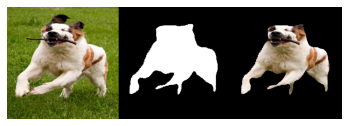

Epoch 16/20
219/219 [==============================] - 73s 332ms/step - loss: 0.1470 - mean_iou: 0.8179 - val_loss: 0.2666 - val_mean_iou: 0.7245
i= 16 loss= 0.14704316296533906 val_loss= 0.2666478157043457 mean_iou= 0.8179046 val_mean_iou= 0.724514365196228


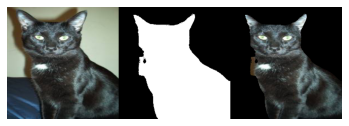

Epoch 17/20
219/219 [==============================] - 73s 333ms/step - loss: 0.1421 - mean_iou: 0.8232 - val_loss: 0.2815 - val_mean_iou: 0.7778
i= 17 loss= 0.14213516086884284 val_loss= 0.28149083256721497 mean_iou= 0.82320297 val_mean_iou= 0.7777997851371765


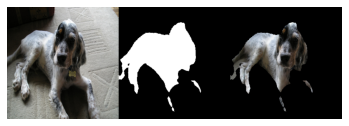

Epoch 18/20
219/219 [==============================] - 72s 329ms/step - loss: 0.1363 - mean_iou: 0.8309 - val_loss: 0.2280 - val_mean_iou: 0.7446
i= 18 loss= 0.13631040684572637 val_loss= 0.22797636687755585 mean_iou= 0.83092344 val_mean_iou= 0.7445695996284485


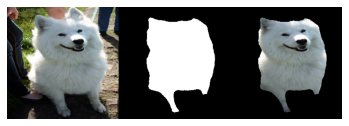

Epoch 19/20
219/219 [==============================] - 72s 329ms/step - loss: 0.1316 - mean_iou: 0.8355 - val_loss: 0.1703 - val_mean_iou: 0.7633
i= 19 loss= 0.13158687775673933 val_loss= 0.170341357588768 mean_iou= 0.83545816 val_mean_iou= 0.7632768750190735


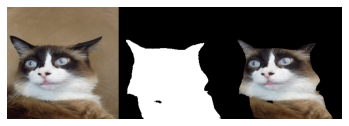

Epoch 20/20
219/219 [==============================] - 73s 333ms/step - loss: 0.1239 - mean_iou: 0.8457 - val_loss: 0.2402 - val_mean_iou: 0.7397
i= 20 loss= 0.12390663920472202 val_loss= 0.24021154642105103 mean_iou= 0.8457085 val_mean_iou= 0.7397133111953735


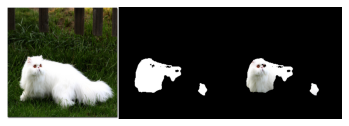

In [11]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 20, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 1)

# Testing

In [12]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-04-17 20:13:37--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.35.7.24, 13.35.7.43, 13.35.7.6, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.35.7.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.004s  

2020-04-17 20:13:37 (16.2 MB/s) - ‘test.jpg’ saved [63219/63219]



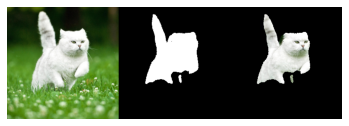

In [13]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

